In [1]:
from perses.utils.openeye import *
from perses.annihilation.relative import HybridTopologyFactory
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.rjmc.geometry import FFAllAngleGeometryEngine

import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np
from openmoltools import forcefield_generators
import copy
import mdtraj as md
from openmmtools.constants import kB
from perses.tests.utils import validate_endstate_energies
from openforcefield.topology import Molecule
from openmmforcefields.generators import SystemGenerator

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
RDKit WARNING: [23:18:11] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import os

In [3]:
ENERGY_THRESHOLD = 1e-2
temperature = 300 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

## Turn off particle charges

In [9]:
class PointMutationExecutor(object):
    def __init__(self,
                 protein_filename,
                 mutation_chain_id,
                 mutation_residue_id,
                 proposed_residue,
                 phase='complex',
                 conduct_endstate_validation=True,
                 ligand_filename=None,
                 ligand_index=0,
                 forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml'],
                 barostat=openmm.MonteCarloBarostat(1.0 * unit.atmosphere, temperature, 50),
                 forcefield_kwargs={'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus},
                 periodic_forcefield_kwargs={'nonbondedMethod': app.PME},
                 nonperiodic_forcefield_kwargs=None,
                 small_molecule_forcefields='gaff-2.11',
                 **kwargs):
        """
        arguments
            protein_filename : str
                path to protein (to mutate); .pdb
            mutation_chain_id : str
                name of the chain to be mutated
            mutation_residue_id : str
                residue id to change
            proposed_residue : str
                three letter code of the residue to mutate to
            phase : str, default complex
                if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
            conduct_endstate_validation : bool, default True
                whether to conduct an endstate validation of the hybrid topology factory
            ligand_filename : str, default None
                path to ligand of interest (i.e. small molecule or protein); .sdf or .pdb
            ligand_index : int, default 0
                which ligand to use
            forcefield_files : list of str, default ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
                forcefield files for proteins and solvent
            barostat : openmm.MonteCarloBarostat, default openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
                barostat to use
            forcefield_kwargs : dict, default {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
                forcefield kwargs for system parametrization
            periodic_forcefield_kwargs : dict, default {'nonbondedMethod': app.PME}
                periodic forcefield kwargs for system parametrization
            nonperiodic_forcefield_kwargs : dict, default None
                non-periodic forcefield kwargs for system parametrization
            small_molecule_forcefields : str, default 'gaff-2.11'
                the forcefield string for small molecule parametrization

        TODO : allow argument for spectator ligands besides the 'ligand_filename'

        """

        # First thing to do is load the apo protein to mutate...
        protein_pdbfile = open(protein_filename, 'r')
        protein_pdb = app.PDBFile(protein_pdbfile)
        protein_pdbfile.close()
        protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
        protein_topology = protein_md_topology.to_openmm()
        protein_n_atoms = protein_md_topology.n_atoms

        # Load the ligand, if present
        molecules = []
        if ligand_filename:
            if ligand_filename.endswith('.sdf'): # small molecule
                ligand_mol = createOEMolFromSDF(ligand_filename, index=ligand_index)
                ligand_mol = generate_unique_atom_names(ligand_mol)
                molecules.append(Molecule.from_openeye(ligand_mol, allow_undefined_stereo=False))
                ligand_positions, ligand_topology = extractPositionsFromOEMol(ligand_mol),  forcefield_generators.generateTopologyFromOEMol(ligand_mol)
                ligand_md_topology = md.Topology.from_openmm(ligand_topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            elif ligand_filename.endswith('pdb'): # protein
                ligand_pdbfile = open(ligand_filename, 'r')
                ligand_pdb = app.PDBFile(ligand_pdbfile)
                ligand_pdbfile.close()
                ligand_positions, ligand_topology, ligand_md_topology = ligand_pdb.positions, ligand_pdb.topology, md.Topology.from_openmm(
                    ligand_pdb.topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            # Now create a complex
            complex_md_topology = protein_md_topology.join(ligand_md_topology)
            complex_topology = complex_md_topology.to_openmm()
            complex_positions = unit.Quantity(np.zeros([protein_n_atoms + ligand_n_atoms, 3]), unit=unit.nanometers)
            complex_positions[:protein_n_atoms, :] = protein_positions
            complex_positions[protein_n_atoms:, :] = ligand_positions

        # Now for a system_generator
        self.system_generator = SystemGenerator(forcefields = forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                small_molecule_forcefield=small_molecule_forcefields,
                                                molecules=molecules,
                                                cache=None)
        self.system_generator.particle_charges = False
        print(self.system_generator.particle_charges)

        # Solvate apo and complex...
        apo_input = list(self._solvate(protein_topology, protein_positions, 'tip3p', phase=phase))
        inputs = [apo_input]
        if ligand_filename:
            inputs.append(self._solvate(complex_topology, complex_positions, 'tip3p', phase=phase))

        geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                                use_sterics=False,
                                                n_bond_divisions=100,
                                                n_angle_divisions=180,
                                                n_torsion_divisions=360,
                                                verbose=True,
                                                storage=None,
                                                bond_softening_constant=1.0,
                                                angle_softening_constant=1.0,
                                                neglect_angles = False,
                                                use_14_nonbondeds = True)


        # Run pipeline...
        htfs = []
        for (top, pos, sys) in inputs:
            point_mutation_engine = PointMutationEngine(wildtype_topology=top,
                                                                 system_generator=self.system_generator,
                                                                 chain_id=mutation_chain_id, # Denote the chain id allowed to mutate (it's always a string variable)
                                                                 max_point_mutants=1,
                                                                 residues_allowed_to_mutate=[mutation_residue_id], # The residue ids allowed to mutate
                                                                 allowed_mutations=[(mutation_residue_id, proposed_residue)], # The residue ids allowed to mutate with the three-letter code allowed to change
                                                                 aggregate=True) # Always allow aggregation

            topology_proposal = point_mutation_engine.propose(sys, top)

            new_positions, logp_proposal = geometry_engine.propose(topology_proposal, pos, beta)
            logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, pos, beta)

            forward_htf = HybridTopologyFactory(topology_proposal=topology_proposal,
                                                 current_positions=pos,
                                                 new_positions=new_positions,
                                                 use_dispersion_correction=False,
                                                 functions=None,
                                                 softcore_alpha=None,
                                                 bond_softening_constant=1.0,
                                                 angle_softening_constant=1.0,
                                                 soften_only_new=False,
                                                 neglected_new_angle_terms=[],
                                                 neglected_old_angle_terms=[],
                                                 softcore_LJ_v2=True,
                                                 softcore_electrostatics=True,
                                                 softcore_LJ_v2_alpha=0.85,
                                                 softcore_electrostatics_alpha=0.3,
                                                 softcore_sigma_Q=1.0,
                                                 interpolate_old_and_new_14s=False,
                                                 omitted_terms=None)

            if not topology_proposal.unique_new_atoms:
                assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
                assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
                vacuum_added_valence_energy = 0.0
            else:
                added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

            if not topology_proposal.unique_old_atoms:
                assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
                assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
                subtracted_valence_energy = 0.0
            else:
                subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


            if conduct_endstate_validation:
                zero_state_error, one_state_error = validate_endstate_energies(forward_htf._topology_proposal, forward_htf, added_valence_energy, subtracted_valence_energy, beta=beta, ENERGY_THRESHOLD=ENERGY_THRESHOLD)
                assert zero_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 0 state is above the threshold ({ENERGY_THRESHOLD}): {zero_state_error}"
                assert one_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 1 state is above the threshold ({ENERGY_THRESHOLD}): {one_state_error}"
            else:
                pass

            htfs.append(forward_htf)

        self.apo_htf = htfs[0]
        self.complex_htf = htfs[1] if ligand_filename else None

    def get_complex_htf(self):
        return self.complex_htf

    def get_apo_htf(self):
        return self.apo_htf


    def _solvate(self,
                        topology,
                        positions,
                        model,
                        phase):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.

        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        model : str, default 'tip3p'
            solvent model to use for solvation

        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)


        # Now we have to add missing atoms
        if phase != 'vacuum':
            modeller.addSolvent(self.system_generator.forcefield, model=model, padding=1.0 * unit.nanometers, ionicStrength=0.15*unit.molar)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [10]:
# Solvent
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                        '1', 
                        '2', 
                        'SER',
                       )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_0/1_0_solvent.pickle"), "wb" ))


DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11


False


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...


ValueError: Can't scale charge product 0 to match -0.053145975

In [7]:
# Vacuum
# Solvent
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                        '1', 
                        '2', 
                        'SER',
                       )

PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                              '1', 
                              '2', 
                              'SER',
                              phase='vacuum',
	                          barostat=None,
	                          periodic_forcefield_kwargs=None, 
	                          nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff}
                             )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_0/1_0_vacuum.pickle"), "wb" ))





DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11


False


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...


ValueError: Can't scale charge product 0 to match -0.053145975

## Turn off exception charges

In [27]:
class PointMutationExecutor(object):
    def __init__(self,
                 protein_filename,
                 mutation_chain_id,
                 mutation_residue_id,
                 proposed_residue,
                 phase='complex',
                 conduct_endstate_validation=True,
                 ligand_filename=None,
                 ligand_index=0,
                 forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml'],
                 barostat=openmm.MonteCarloBarostat(1.0 * unit.atmosphere, temperature, 50),
                 forcefield_kwargs={'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus},
                 periodic_forcefield_kwargs={'nonbondedMethod': app.PME},
                 nonperiodic_forcefield_kwargs=None,
                 small_molecule_forcefields='gaff-2.11',
                 **kwargs):
        """
        arguments
            protein_filename : str
                path to protein (to mutate); .pdb
            mutation_chain_id : str
                name of the chain to be mutated
            mutation_residue_id : str
                residue id to change
            proposed_residue : str
                three letter code of the residue to mutate to
            phase : str, default complex
                if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
            conduct_endstate_validation : bool, default True
                whether to conduct an endstate validation of the hybrid topology factory
            ligand_filename : str, default None
                path to ligand of interest (i.e. small molecule or protein); .sdf or .pdb
            ligand_index : int, default 0
                which ligand to use
            forcefield_files : list of str, default ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
                forcefield files for proteins and solvent
            barostat : openmm.MonteCarloBarostat, default openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
                barostat to use
            forcefield_kwargs : dict, default {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
                forcefield kwargs for system parametrization
            periodic_forcefield_kwargs : dict, default {'nonbondedMethod': app.PME}
                periodic forcefield kwargs for system parametrization
            nonperiodic_forcefield_kwargs : dict, default None
                non-periodic forcefield kwargs for system parametrization
            small_molecule_forcefields : str, default 'gaff-2.11'
                the forcefield string for small molecule parametrization

        TODO : allow argument for spectator ligands besides the 'ligand_filename'

        """

        # First thing to do is load the apo protein to mutate...
        protein_pdbfile = open(protein_filename, 'r')
        protein_pdb = app.PDBFile(protein_pdbfile)
        protein_pdbfile.close()
        protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
        protein_topology = protein_md_topology.to_openmm()
        protein_n_atoms = protein_md_topology.n_atoms

        # Load the ligand, if present
        molecules = []
        if ligand_filename:
            if ligand_filename.endswith('.sdf'): # small molecule
                ligand_mol = createOEMolFromSDF(ligand_filename, index=ligand_index)
                ligand_mol = generate_unique_atom_names(ligand_mol)
                molecules.append(Molecule.from_openeye(ligand_mol, allow_undefined_stereo=False))
                ligand_positions, ligand_topology = extractPositionsFromOEMol(ligand_mol),  forcefield_generators.generateTopologyFromOEMol(ligand_mol)
                ligand_md_topology = md.Topology.from_openmm(ligand_topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            elif ligand_filename.endswith('pdb'): # protein
                ligand_pdbfile = open(ligand_filename, 'r')
                ligand_pdb = app.PDBFile(ligand_pdbfile)
                ligand_pdbfile.close()
                ligand_positions, ligand_topology, ligand_md_topology = ligand_pdb.positions, ligand_pdb.topology, md.Topology.from_openmm(
                    ligand_pdb.topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            # Now create a complex
            complex_md_topology = protein_md_topology.join(ligand_md_topology)
            complex_topology = complex_md_topology.to_openmm()
            complex_positions = unit.Quantity(np.zeros([protein_n_atoms + ligand_n_atoms, 3]), unit=unit.nanometers)
            complex_positions[:protein_n_atoms, :] = protein_positions
            complex_positions[protein_n_atoms:, :] = ligand_positions

        # Now for a system_generator
        self.system_generator = SystemGenerator(forcefields = forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                small_molecule_forcefield=small_molecule_forcefields,
                                                molecules=molecules,
                                                cache=None)
        self.system_generator.exception_charges = False
        print(self.system_generator.exception_charges)

        # Solvate apo and complex...
        apo_input = list(self._solvate(protein_topology, protein_positions, 'tip3p', phase=phase))
        inputs = [apo_input]
        if ligand_filename:
            inputs.append(self._solvate(complex_topology, complex_positions, 'tip3p', phase=phase))

        geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                                use_sterics=False,
                                                n_bond_divisions=100,
                                                n_angle_divisions=180,
                                                n_torsion_divisions=360,
                                                verbose=True,
                                                storage=None,
                                                bond_softening_constant=1.0,
                                                angle_softening_constant=1.0,
                                                neglect_angles = False,
                                                use_14_nonbondeds = True)


        # Run pipeline...
        htfs = []
        for (top, pos, sys) in inputs:
            point_mutation_engine = PointMutationEngine(wildtype_topology=top,
                                                                 system_generator=self.system_generator,
                                                                 chain_id=mutation_chain_id, # Denote the chain id allowed to mutate (it's always a string variable)
                                                                 max_point_mutants=1,
                                                                 residues_allowed_to_mutate=[mutation_residue_id], # The residue ids allowed to mutate
                                                                 allowed_mutations=[(mutation_residue_id, proposed_residue)], # The residue ids allowed to mutate with the three-letter code allowed to change
                                                                 aggregate=True) # Always allow aggregation

            topology_proposal = point_mutation_engine.propose(sys, top)

            new_positions, logp_proposal = geometry_engine.propose(topology_proposal, pos, beta)
            logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, pos, beta)

            forward_htf = HybridTopologyFactory(topology_proposal=topology_proposal,
                                                 current_positions=pos,
                                                 new_positions=new_positions,
                                                 use_dispersion_correction=False,
                                                 functions=None,
                                                 softcore_alpha=None,
                                                 bond_softening_constant=1.0,
                                                 angle_softening_constant=1.0,
                                                 soften_only_new=False,
                                                 neglected_new_angle_terms=[],
                                                 neglected_old_angle_terms=[],
                                                 softcore_LJ_v2=True,
                                                 softcore_electrostatics=True,
                                                 softcore_LJ_v2_alpha=0.85,
                                                 softcore_electrostatics_alpha=0.3,
                                                 softcore_sigma_Q=1.0,
                                                 interpolate_old_and_new_14s=False,
                                                 omitted_terms=None)

            if not topology_proposal.unique_new_atoms:
                assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
                assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
                vacuum_added_valence_energy = 0.0
            else:
                added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

            if not topology_proposal.unique_old_atoms:
                assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
                assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
                subtracted_valence_energy = 0.0
            else:
                subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


            if conduct_endstate_validation:
                zero_state_error, one_state_error = validate_endstate_energies(forward_htf._topology_proposal, forward_htf, added_valence_energy, subtracted_valence_energy, beta=beta, ENERGY_THRESHOLD=ENERGY_THRESHOLD)
                assert zero_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 0 state is above the threshold ({ENERGY_THRESHOLD}): {zero_state_error}"
                assert one_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 1 state is above the threshold ({ENERGY_THRESHOLD}): {one_state_error}"
            else:
                pass

            htfs.append(forward_htf)

        self.apo_htf = htfs[0]
        self.complex_htf = htfs[1] if ligand_filename else None

    def get_complex_htf(self):
        return self.complex_htf

    def get_apo_htf(self):
        return self.apo_htf


    def _solvate(self,
                        topology,
                        positions,
                        model,
                        phase):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.

        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        model : str, default 'tip3p'
            solvent model to use for solvation

        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)


        # Now we have to add missing atoms
        if phase != 'vacuum':
            modeller.addSolvent(self.system_generator.forcefield, model=model, padding=1.0 * unit.nanometers, ionicStrength=0.15*unit.molar)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [28]:
# Solvent
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                        '1', 
                        '2', 
                        'SER',
                       )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_1/1_1_solvent.pickle"), "wb" ))


DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11


False


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 10 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 37 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geome

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.18099365606738368.
INFO:geometry:	reduced angle potential = 0.04850314560305327.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 7.767700716743353
INFO:geometry:final reduced energy 24.590294389223928
INFO:geometry:sum of energies: 24.590294676350204
INFO:geometry:magnitude of difference in the energies: 2.8712627742066843e-07
INFO:geometry:Final logp_proposal: 15.04313685705439


added energy components: [('CustomBondForce', 0.26707825579464184), ('CustomAngleForce', 0.32630578833555884), ('CustomTorsionForce', 4.5579658906021026), ('CustomBondForce', 2.6163507820110485)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geomet

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 1 new atoms
INFO:geometry:	reduced angle potential = 1.1491328110690509.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 2.3827173675554696
INFO:geometry:final reduced energy 19.205311318449255
INFO:geometry:sum of energies: 19.20531132716232
INFO:geometry:magnitude of difference in the energies: 8.713067156662646e-09
INFO:geometry:Final logp_proposal: 5.47127340796711


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 0.8610735058596388)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 4
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.7648, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.7648, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.7648), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.03336689198711389
			HarmonicAngleForce: 2.1347394429482724
			PeriodicTorsionForce: 16.176131477654224
			NonbondedForce: -1260.1681773172213
			AndersenThermostat: 0.0
			MonteCarloBarostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.0333668919871139
			HarmonicBondForce: 0.2670782557946219
			CustomAngleForce: 0.6152838082371311
			HarmonicAngleForce: 1.84576142304672
			CustomTorsionForce: 0.0
			PeriodicTorsionForce: 20.734097081130066
			NonbondedForce: -1244.427188266569
			CustomNonbondedForce: -13.124700578959537
			CustomBondForce: 0.0
			AndersenThermostat: 0.0
			MonteCarloBarostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.0333668919871139
			HarmonicBondForce: 0.2670782557946219
			CustomAngleForce: 0.6152838082371311
			HarmonicAngleForce: 

In [29]:
# Vacuum
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                              '1', 
                              '2', 
                              'SER',
                              phase='vacuum',
	                          barostat=None,
	                          periodic_forcefield_kwargs=None, 
	                          nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff}
                             )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_1/1_1_vacuum.pickle"), "wb" ))





DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 10 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 37 angles in reference force.
INFO:geom

False
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions
INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.005109457002994484.


conducting subsequent work with the following platform: CUDA


INFO:geometry:	reduced angle potential = 0.13213791406707062.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 8.348406171043665
INFO:geometry:final reduced energy 25.17100041405495
INFO:geometry:sum of energies: 25.17100013065052
INFO:geometry:magnitude of difference in the energies: 2.8340443414265337e-07
INFO:geometry:Final logp_proposal: 14.146556084180006


added energy components: [('CustomBondForce', 0.7474483096762549), ('CustomAngleForce', 0.6246826725575791), ('CustomTorsionForce', 4.711276533485404), ('CustomBondForce', 2.264998655324426)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geomet

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions
INFO:geometry:There are 1 new atoms
INFO:geometry:	reduced angle potential = 1.1491328110690509.


conducting subsequent work with the following platform: CUDA


INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 2.3827173675554696
INFO:geometry:final reduced energy 19.205311318449187
INFO:geometry:sum of energies: 19.20531132716232
INFO:geometry:magnitude of difference in the energies: 8.713134658222543e-09
INFO:geometry:Final logp_proposal: 5.478366961291566


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 0.8610735058596388)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.0333668919871159
			HarmonicAngleForce: 2.134739442948204
			PeriodicTorsionForce: 16.17613147765423
			NonbondedForce: -120.90634830092895
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 0.7474483096762549
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.144138307268652
			CustomTorsionForce: 0.0
			PeriodicTorsionForce: 20.887408294544073
			NonbondedForce: -123.34593171851924
			CustomNonbondedForce: 4.704582417313628
			CustomBondForce: 0.0
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 0.7474483096762549
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.144138307268652
			CustomTorsionForce: 0.0
			Perio

## Turn off both particle charges and exceptions charges

In [16]:
class PointMutationExecutor(object):
    def __init__(self,
                 protein_filename,
                 mutation_chain_id,
                 mutation_residue_id,
                 proposed_residue,
                 phase='complex',
                 conduct_endstate_validation=True,
                 ligand_filename=None,
                 ligand_index=0,
                 forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml'],
                 barostat=openmm.MonteCarloBarostat(1.0 * unit.atmosphere, temperature, 50),
                 forcefield_kwargs={'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus},
                 periodic_forcefield_kwargs={'nonbondedMethod': app.PME},
                 nonperiodic_forcefield_kwargs=None,
                 small_molecule_forcefields='gaff-2.11',
                 **kwargs):
        """
        arguments
            protein_filename : str
                path to protein (to mutate); .pdb
            mutation_chain_id : str
                name of the chain to be mutated
            mutation_residue_id : str
                residue id to change
            proposed_residue : str
                three letter code of the residue to mutate to
            phase : str, default complex
                if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
            conduct_endstate_validation : bool, default True
                whether to conduct an endstate validation of the hybrid topology factory
            ligand_filename : str, default None
                path to ligand of interest (i.e. small molecule or protein); .sdf or .pdb
            ligand_index : int, default 0
                which ligand to use
            forcefield_files : list of str, default ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
                forcefield files for proteins and solvent
            barostat : openmm.MonteCarloBarostat, default openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
                barostat to use
            forcefield_kwargs : dict, default {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
                forcefield kwargs for system parametrization
            periodic_forcefield_kwargs : dict, default {'nonbondedMethod': app.PME}
                periodic forcefield kwargs for system parametrization
            nonperiodic_forcefield_kwargs : dict, default None
                non-periodic forcefield kwargs for system parametrization
            small_molecule_forcefields : str, default 'gaff-2.11'
                the forcefield string for small molecule parametrization

        TODO : allow argument for spectator ligands besides the 'ligand_filename'

        """

        # First thing to do is load the apo protein to mutate...
        protein_pdbfile = open(protein_filename, 'r')
        protein_pdb = app.PDBFile(protein_pdbfile)
        protein_pdbfile.close()
        protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
        protein_topology = protein_md_topology.to_openmm()
        protein_n_atoms = protein_md_topology.n_atoms

        # Load the ligand, if present
        molecules = []
        if ligand_filename:
            if ligand_filename.endswith('.sdf'): # small molecule
                ligand_mol = createOEMolFromSDF(ligand_filename, index=ligand_index)
                ligand_mol = generate_unique_atom_names(ligand_mol)
                molecules.append(Molecule.from_openeye(ligand_mol, allow_undefined_stereo=False))
                ligand_positions, ligand_topology = extractPositionsFromOEMol(ligand_mol),  forcefield_generators.generateTopologyFromOEMol(ligand_mol)
                ligand_md_topology = md.Topology.from_openmm(ligand_topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            elif ligand_filename.endswith('pdb'): # protein
                ligand_pdbfile = open(ligand_filename, 'r')
                ligand_pdb = app.PDBFile(ligand_pdbfile)
                ligand_pdbfile.close()
                ligand_positions, ligand_topology, ligand_md_topology = ligand_pdb.positions, ligand_pdb.topology, md.Topology.from_openmm(
                    ligand_pdb.topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            # Now create a complex
            complex_md_topology = protein_md_topology.join(ligand_md_topology)
            complex_topology = complex_md_topology.to_openmm()
            complex_positions = unit.Quantity(np.zeros([protein_n_atoms + ligand_n_atoms, 3]), unit=unit.nanometers)
            complex_positions[:protein_n_atoms, :] = protein_positions
            complex_positions[protein_n_atoms:, :] = ligand_positions

        # Now for a system_generator
        self.system_generator = SystemGenerator(forcefields = forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                small_molecule_forcefield=small_molecule_forcefields,
                                                molecules=molecules,
                                                cache=None)
        self.system_generator.particle_charges = False
        self.system_generator.exception_charges = False
        print(self.system_generator.particle_charges)
        print(self.system_generator.exception_charges)

        # Solvate apo and complex...
        apo_input = list(self._solvate(protein_topology, protein_positions, 'tip3p', phase=phase))
        inputs = [apo_input]
        if ligand_filename:
            inputs.append(self._solvate(complex_topology, complex_positions, 'tip3p', phase=phase))

        geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                                use_sterics=False,
                                                n_bond_divisions=100,
                                                n_angle_divisions=180,
                                                n_torsion_divisions=360,
                                                verbose=True,
                                                storage=None,
                                                bond_softening_constant=1.0,
                                                angle_softening_constant=1.0,
                                                neglect_angles = False,
                                                use_14_nonbondeds = True)


        # Run pipeline...
        htfs = []
        for (top, pos, sys) in inputs:
            point_mutation_engine = PointMutationEngine(wildtype_topology=top,
                                                                 system_generator=self.system_generator,
                                                                 chain_id=mutation_chain_id, # Denote the chain id allowed to mutate (it's always a string variable)
                                                                 max_point_mutants=1,
                                                                 residues_allowed_to_mutate=[mutation_residue_id], # The residue ids allowed to mutate
                                                                 allowed_mutations=[(mutation_residue_id, proposed_residue)], # The residue ids allowed to mutate with the three-letter code allowed to change
                                                                 aggregate=True) # Always allow aggregation

            topology_proposal = point_mutation_engine.propose(sys, top)

            new_positions, logp_proposal = geometry_engine.propose(topology_proposal, pos, beta)
            logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, pos, beta)
            
            forward_htf = HybridTopologyFactory(topology_proposal=topology_proposal,
                                                 current_positions=pos,
                                                 new_positions=new_positions,
                                                 use_dispersion_correction=False,
                                                 functions=None,
                                                 softcore_alpha=None,
                                                 bond_softening_constant=1.0,
                                                 angle_softening_constant=1.0,
                                                 soften_only_new=False,
                                                 neglected_new_angle_terms=[],
                                                 neglected_old_angle_terms=[],
                                                 softcore_LJ_v2=True,
                                                 softcore_electrostatics=True,
                                                 softcore_LJ_v2_alpha=0.85,
                                                 softcore_electrostatics_alpha=0.3,
                                                 softcore_sigma_Q=1.0,
                                                 interpolate_old_and_new_14s=False,
                                                 omitted_terms=None)

            if not topology_proposal.unique_new_atoms:
                assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
                assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
                vacuum_added_valence_energy = 0.0
            else:
                added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

            if not topology_proposal.unique_old_atoms:
                assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
                assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
                subtracted_valence_energy = 0.0
            else:
                subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


            if conduct_endstate_validation:
                zero_state_error, one_state_error = validate_endstate_energies(forward_htf._topology_proposal, forward_htf, added_valence_energy, subtracted_valence_energy, beta=beta, ENERGY_THRESHOLD=ENERGY_THRESHOLD)
                assert zero_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 0 state is above the threshold ({ENERGY_THRESHOLD}): {zero_state_error}"
                assert one_state_error < ENERGY_THRESHOLD, f"Reduced potential difference of the nonalchemical and alchemical Lambda = 1 state is above the threshold ({ENERGY_THRESHOLD}): {one_state_error}"
            else:
                pass

            htfs.append(forward_htf)

        self.apo_htf = htfs[0]
        self.complex_htf = htfs[1] if ligand_filename else None

    def get_complex_htf(self):
        return self.complex_htf

    def get_apo_htf(self):
        return self.apo_htf


    def _solvate(self,
                        topology,
                        positions,
                        model,
                        phase):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.

        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        model : str, default 'tip3p'
            solvent model to use for solvation

        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)


        # Now we have to add missing atoms
        if phase != 'vacuum':
            modeller.addSolvent(self.system_generator.forcefield, model=model, padding=1.0 * unit.nanometers, ionicStrength=0.15*unit.molar)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [31]:
# Solvent
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                        '1', 
                        '2', 
                        'SER',
                       )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_0/1_0_solvent.pickle"), "wb" ))


DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11


False
False


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 10 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 37 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geome

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.16383633729719527.
INFO:geometry:	reduced angle potential = 0.00010671999383224757.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 8.812391446686751
INFO:geometry:final reduced energy 25.63498554625531
INFO:geometry:sum of energies: 25.634985406293602
INFO:geometry:magnitude of difference in the energies: 1.3996170800112395e-07
INFO:geometry:Final logp_proposal: 14.390405796480529


added energy components: [('CustomBondForce', 0.16195994259159927), ('CustomAngleForce', 0.3385365156508474), ('CustomTorsionForce', 5.383540504784303), ('CustomBondForce', 2.9283544836600006)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geomet

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 1 new atoms
INFO:geometry:	reduced angle potential = 1.1491328110690509.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 2.3827173675554696
INFO:geometry:final reduced energy 19.205311318449255
INFO:geometry:sum of energies: 19.20531132716232
INFO:geometry:magnitude of difference in the energies: 8.713067156662646e-09
INFO:geometry:Final logp_proposal: 5.478455681879505


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 0.8610735058596388)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 4
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.7648, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.7648, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.7648), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.03336689198711389
			HarmonicAngleForce: 2.1347394429482724
			PeriodicTorsionForce: 16.176131477654224
			NonbondedForce: 9444.307740542246
			AndersenThermostat: 0.0
			MonteCarloBarostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.0333668919871139
			HarmonicBondForce: 0.16195994259164068
			CustomAngleForce: 0.6152838082371311
			HarmonicAngleForce: 1.857992150362015
			CustomTorsionForce: 0.0
			PeriodicTorsionForce: 21.559672122400173
			NonbondedForce: 9460.353914365642
			CustomNonbondedForce: -13.117819383782063
			CustomBondForce: 0.0
			AndersenThermostat: 0.0
			MonteCarloBarostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.0333668919871139
			HarmonicBondForce: 0.16195994259164068
			CustomAngleForce: 0.6152838082371311
			HarmonicAngleForce: 

In [32]:
# Vacuum
import pickle
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/4/"

# Create hybrid topology factory
apo_delivery = PointMutationExecutor(f"../input/ala_vacuum.pdb", 
                              '1', 
                              '2', 
                              'SER',
                              phase='vacuum',
	                          barostat=None,
	                          periodic_forcefield_kwargs=None, 
	                          nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff}
                             )
pickle.dump(apo_delivery.get_apo_htf(), open(os.path.join(output_dir, "1_0/1_0_vacuum.pickle"), "wb" ))





DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 10 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 37 angles in reference force.
INFO:geom

False
False
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions
INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.16125885677578072.


conducting subsequent work with the following platform: CUDA


INFO:geometry:	reduced angle potential = 0.5845874409487455.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 7.053569060515318
INFO:geometry:final reduced energy 23.876163076790462
INFO:geometry:sum of energies: 23.87616302012217
INFO:geometry:magnitude of difference in the energies: 5.666829228090364e-08
INFO:geometry:Final logp_proposal: 14.59961415146008


added energy components: [('CustomBondForce', 0.00026925830342821027), ('CustomAngleForce', 1.0163406347511896), ('CustomTorsionForce', 4.505356298780916), ('CustomBondForce', 1.5316028686797842)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geomet

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions
INFO:geometry:There are 1 new atoms


conducting subsequent work with the following platform: CUDA


INFO:geometry:	reduced angle potential = 1.1491328110690509.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 2.3827173675554696
INFO:geometry:final reduced energy 19.205311318449187
INFO:geometry:sum of energies: 19.20531132716232
INFO:geometry:magnitude of difference in the energies: 8.713134658222543e-09
INFO:geometry:Final logp_proposal: 5.478455681879505


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 0.8610735058596388)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.0333668919871159
			HarmonicAngleForce: 2.134739442948204
			PeriodicTorsionForce: 16.17613147765423
			NonbondedForce: 13.552265347755618
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 0.00026925830342821027
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.5357962694622627
			CustomTorsionForce: 0.0
			PeriodicTorsionForce: 20.681487833103443
			NonbondedForce: 10.379286143520723
			CustomNonbondedForce: 4.704582417313628
			CustomBondForce: 0.0
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 0.00026925830342821027
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.5357962694622627
			CustomTorsionForce: 0.0


## analyze

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
# Global variables
amino_acids = ['ALA', 'CYS', 'SER', 'THR']

# Create list of tuples for every pair of amino acids
pairs = list(itertools.permutations(amino_acids, r=2))

In [3]:
def analyze(forward_work, reverse_work, forward_accumulated, reverse_accumulated, dir_num, phase, output_dir, title): 
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    # Compute dg, ddg
    print("computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ps)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    
    # Compute free energy 
    return dg, ddg
    

In [4]:
# Prep work arrays (from distributed jobs) and call analyze()
d_results = {}
for i in ['1']:
    print(f"dir: {i}")
    # Load and combine arrays
    forward_solvent_arrays = []
    reverse_solvent_arrays = []
    forward_vacuum_arrays = []
    reverse_vacuum_arrays = []
    for j in tqdm_notebook(range(10)):
        print(f"job: {j}")
        forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/7/{i}/{i}_solvent_{j}_forward.npy'
        reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/7/{i}/{i}_solvent_{j}_reverse.npy'
        forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/7/{i}/{i}_vacuum_{j}_forward.npy'
        reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/7/{i}/{i}_vacuum_{j}_reverse.npy'
        if os.path.exists(forward_solvent_path):
            with open(forward_solvent_path, 'rb') as f:
                forward_solvent_arrays.append(np.load(f))
        if os.path.exists(reverse_solvent_path):
            with open(reverse_solvent_path, 'rb') as f:
                reverse_solvent_arrays.append(np.load(f))
        if os.path.exists(forward_vacuum_path):
            with open(forward_vacuum_path, 'rb') as f:
                forward_vacuum_arrays.append(np.load(f))
        if os.path.exists(reverse_vacuum_path):
            with open(reverse_vacuum_path, 'rb') as f:
                reverse_vacuum_arrays.append(np.load(f))
    if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
#     if forward_vacuum_arrays and reverse_vacuum_arrays:
        
        forward_solvent_combined = np.concatenate(forward_solvent_arrays)
        print(forward_solvent_combined.shape)
        forward_solvent_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_solvent_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
#         forward_solvent_combined = np.array([cycle[0::100] for cycle in forward_solvent_combined])
        
        reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
        reverse_solvent_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_solvent_combined])
#         reverse_solvent_combined = np.array([cycle[0::100] for cycle in reverse_solvent_combined])
        
        forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
        print(forward_vacuum_combined.shape)
        forward_vacuum_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_vacuum_combined])
#         forward_vacuum_combined = np.array([cycle[0::100] for cycle in forward_vacuum_combined])
        
        reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)
        reverse_vacuum_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_vacuum_combined])
#         reverse_vacuum_combined = np.array([cycle[0::100] for cycle in reverse_vacuum_combined])
    
        
        # Analyze
#         solvent_dg, solvent_ddg = analyze(forward_solvent_combined, reverse_solvent_combined, forward_solvent_accumulated, reverse_solvent_accumulated, i, 'solvent', os.path.dirname(forward_solvent_path), pairs[i])
        print(i)
        vacuum_dg, vacuum_ddg = analyze(forward_vacuum_combined, reverse_vacuum_combined, forward_vacuum_accumulated, reverse_vacuum_accumulated, i, 'vacuum', os.path.dirname(forward_vacuum_path), f"{pairs[1][0]}->{pairs[1][1]}")
#         solvation_dg = vacuum_dg - solvent_dg
#         solvation_ddg = (vacuum_ddg**2 + solvent_ddg**2)**0.5
#         d_results[pairs[1]] = [solvation_dg, solvation_ddg]
#         print(f"vacuum dg: {vacuum_dg}, solvent_dg: {solvent_dg}")
        print(vacuum_dg, vacuum_ddg)
    else:
        print(f"dir {i} has at least one phase without data" )

dir: 1


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

dir 1 has at least one phase without data


In [6]:
# Prep work arrays (from distributed jobs) and call analyze()
d_results = {}
for i in ['1_12']:
    print(f"dir: {i}")
    # Load and combine arrays
    forward_solvent_arrays = []
    reverse_solvent_arrays = []
    forward_vacuum_arrays = []
    reverse_vacuum_arrays = []
    for j in tqdm_notebook(range(100)):
        print(f"job: {j}")
        forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/4/{i}/{i}_solvent_{j}_forward.npy'
        reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/4/{i}/{i}_solvent_{j}_reverse.npy'
        forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/4/{i}/{i}_vacuum_{j}_forward.npy'
        reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/4/{i}/{i}_vacuum_{j}_reverse.npy'
#         if os.path.exists(forward_solvent_path):
#             with open(forward_solvent_path, 'rb') as f:
#                 forward_solvent_arrays.append(np.load(f))
#         if os.path.exists(reverse_solvent_path):
#             with open(reverse_solvent_path, 'rb') as f:
#                 reverse_solvent_arrays.append(np.load(f))
        if os.path.exists(forward_vacuum_path):
            with open(forward_vacuum_path, 'rb') as f:
                forward_vacuum_arrays.append(np.load(f))
        if os.path.exists(reverse_vacuum_path):
            with open(reverse_vacuum_path, 'rb') as f:
                reverse_vacuum_arrays.append(np.load(f))
#     if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
    if forward_vacuum_arrays and reverse_vacuum_arrays:
        forward_solvent_combined = np.concatenate(forward_solvent_arrays)
        reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
        
        # Save every 100 steps
        forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
        print(forward_vacuum_combined.shape)
#         forward_vacuum_combined = np.array([cycle[0::10] for cycle in forward_vacuum_combined])
#         print(forward_vacuum_combined.shape)
        reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)
        print(reverse_vacuum_combined.shape)
#         reverse_vacuum_combined = np.array([cycle[0::10] for cycle in reverse_vacuum_combined])
#         print(reverse_vacuum_combined.shape)
        # Analyze
        solvent_dg, solvent_ddg = analyze(forward_solvent_combined, reverse_solvent_combined, 1, 'solvent', os.path.dirname(forward_solvent_path))
        vacuum_dg, vacuum_ddg = analyze(forward_vacuum_combined, reverse_vacuum_combined, 1, 'vacuum', os.path.dirname(forward_vacuum_path))
        print(f"vacuum dg: {vacuum_dg}")
    #         solvation_dg = vacuum_dg - solvent_dg
# #         solvation_ddg = (vacuum_ddg**2 + solvent_ddg**2)**0.5
#         d_results[pairs[1]] = [solvation_dg, solvation_ddg]
#         print(f"vacuum dg: {vacuum_dg}, solvent_dg: {solvent_dg}")
    else:
        print(f"dir {i} has at least one phase without data" )

dir: 1_12


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
job: 20
job: 21
job: 22
job: 23
job: 24
job: 25
job: 26
job: 27
job: 28
job: 29
job: 30
job: 31
job: 32
job: 33
job: 34
job: 35
job: 36
job: 37
job: 38
job: 39
job: 40
job: 41
job: 42
job: 43
job: 44
job: 45
job: 46
job: 47
job: 48
job: 49
job: 50
job: 51
job: 52
job: 53
job: 54
job: 55
job: 56
job: 57
job: 58
job: 59
job: 60
job: 61
job: 62
job: 63
job: 64
job: 65
job: 66
job: 67
job: 68
job: 69
job: 70
job: 71
job: 72
job: 73
job: 74
job: 75
job: 76
job: 77
job: 78
job: 79
job: 80
job: 81
job: 82
job: 83
job: 84
job: 85
job: 86
job: 87
job: 88
job: 89
job: 90
job: 91
job: 92
job: 93
job: 94
job: 95
job: 96
job: 97
job: 98
job: 99



ValueError: need at least one array to concatenate

In [9]:
forward_vacuum_combined.shape

(100, 375001)

## Turn off only exceptions and charge of the thiol/alcohol hydrogen

In [ ]:
# see run_neq_distrib_no_elec.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np

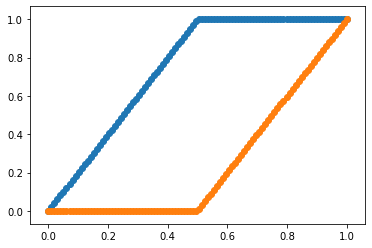

In [12]:
x = np.linspace(0.,1.,100)
inflection = 0.5
y = [1.-(i/inflection) if i < inflection else 0. for i in x]
plt.scatter(x,1 - np.array(y))
y = [0. if i < (1-inflection) else 1+ (i-1)/(inflection) for i in x]
plt.scatter(x,y)

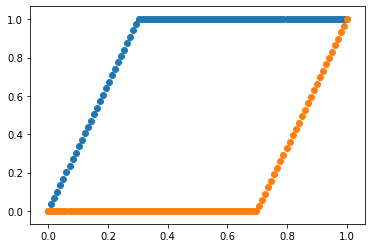

In [15]:
x = np.linspace(0.,1.,100)
inflection = 0.3
y = [1.-(i/inflection) if i < inflection else 0. for i in x]
plt.scatter(x,1 - np.array(y))
y = [0. if i < (1-inflection) else 1+ (i-1)/(inflection) for i in x]
plt.scatter(x,y)

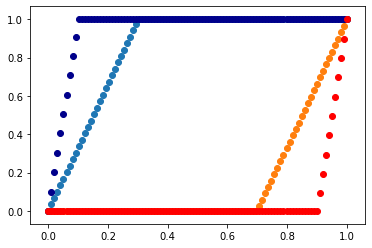

In [18]:
x = np.linspace(0.,1.,100)
inflection = 0.3
y = [1.-(i/inflection) if i < inflection else 0. for i in x]
plt.scatter(x,1 - np.array(y))
y = [0. if i < (1-inflection) else 1+ (i-1)/(inflection) for i in x]
plt.scatter(x,y)

x = np.linspace(0.,1.,100)
inflection = 0.1
y = [1.-(i/inflection) if i < inflection else 0. for i in x]
plt.scatter(x,1 - np.array(y), color='darkblue')
y = [0. if i < (1-inflection) else 1+ (i-1)/(inflection) for i in x]
plt.scatter(x,y, color='red')



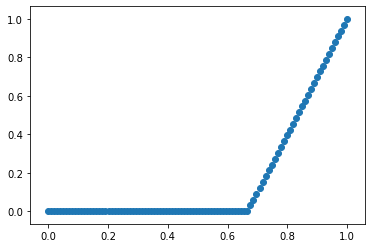

In [ ]:
y = [0. if i < (1-inflection) else 1+ (i-1)/(inflection) for i in x]
plt.scatter(x,y)

## Check lambda protocols

In [1]:
x = 'lambda'
inflection = '0.9'
custom_functions = {
                             'lambda_sterics_core': x,
                             'lambda_electrostatics_core': x,
                             'lambda_sterics_insert': f"select(step({x} - 0.5), 1.0, 2.0 * {x})",
                             'lambda_sterics_delete': f"select(step({x} - 0.5), 2.0 * ({x} - 0.5), 0.0)",
                             'lambda_electrostatics_insert': f"select(step({x} - (1. - {inflection})), (1./{inflection}) * ({x} - (1. - {inflection})), 0.0)",
                             'lambda_electrostatics_delete': f"select(step({x} - {inflection}), 1.0, (1./{inflection}) * {x})",
                             'lambda_bonds': x,
                             'lambda_angles': x,
                             'lambda_torsions': x}



In [2]:
import simtk.unit as unit
# Define simulation parameters
nsteps_eq = 1 
nsteps_neq = 10
neq_splitting='V R H O R V'
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'



In [5]:
import pickle
# Read in htf
with open("/data/chodera/zhangi/perses_benchmark/neq/3/1/1_vacuum.pickle", 'rb') as f:
    htf = pickle.load(f)
system = htf.hybrid_system
positions = htf.hybrid_positions



In [6]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (SER)>
<Atom 7 (H) of chain 0 residue 1 (SER)>
<Atom 8 (CA) of chain 0 residue 1 (SER)>
<Atom 9 (HA) of chain 0 residue 1 (SER)>
<Atom 10 (CB) of chain 0 residue 1 (SER)>
<Atom 11 (HB2) of chain 0 residue 1 (SER)>
<Atom 12 (HB3) of chain 0 residue 1 (SER)>
<Atom 13 (C) of chain 0 residue 1 (SER)>
<Atom 14 (O) of chain 0 residue 1 (SER)>
<Atom 15 (OG) of chain 0 residue 1 (SER)>
<Atom 16 (HG) of chain 0 residue 1 (SER)>
<Atom 17 (N) of chain 0 residue 2 (NME)>
<Atom 18 (H) of chain 0 residue 2 (NME)>
<Atom 19 (C) of chain 0 residue 2 (NME)>
<Atom 20 (H1) of chain 0 residue 2 (NME)>
<Atom 21 (H2) of chain 0 residue 2 (NME)>
<Atom 22 (H3) of chain 0 residue 2 (NME)>
<Atom 23 (O) of chain 1 residue 3 (HOH)>
<Atom 24 

In [7]:
from openmmtools.integrators import PeriodicNonequilibriumIntegrator

# Set up integrator
integrator = PeriodicNonequilibriumIntegrator(custom_functions, nsteps_eq, nsteps_neq, neq_splitting, timestep=timestep)

from simtk import openmm
# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')
context = openmm.Context(system, integrator, platform)
context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(positions)



In [8]:
openmm.LocalEnergyMinimizer.minimize(context)


In [9]:
import logging
_logger = logging.getLogger()
_logger.setLevel(logging.DEBUG)
import time

for cycle in range(1):
    # Equilibrium (lambda = 0)
    _logger.info(f'Cycle: {cycle}, Starting to equilibrate at lambda = 0')
    initial_time = time.time()
    integrator.step(nsteps_eq)
    elapsed_time = (time.time() - initial_time) * unit.seconds
    swig_parameters = context.getParameters()
    context_parameters = {q: swig_parameters[q] for q in swig_parameters}
    _logger.info(f"delete: {context_parameters['lambda_electrostatics_delete']}")
    _logger.info(f"insert: {context_parameters['lambda_electrostatics_insert']}")
    _logger.info(f'Cycle: {cycle}, Done equilibrating at lambda = 0, took: {elapsed_time / unit.seconds} seconds')

    # Forward (0 -> 1)
    for fwd_step in range(nsteps_neq):
        initial_time = time.time()
        integrator.step(1)
        swig_parameters = context.getParameters()
        context_parameters = {q: swig_parameters[q] for q in swig_parameters}
        elapsed_time = (time.time() - initial_time) * unit.seconds
        _logger.info(f"delete: {context_parameters['lambda_electrostatics_delete']}")
        _logger.info(f"insert: {context_parameters['lambda_electrostatics_insert']}")
        _logger.info(f'Cycle: {cycle}, forward NEQ step: {fwd_step}, took: {elapsed_time / unit.seconds} seconds')

    # Equilibrium (lambda = 1)
    _logger.info(f'Cycle: {cycle}, Starting to equilibrate at lambda = 1')
    initial_time = time.time()
    integrator.step(nsteps_eq)
    elapsed_time = (time.time() - initial_time) * unit.seconds
    swig_parameters = context.getParameters()
    context_parameters = {q: swig_parameters[q] for q in swig_parameters}
    _logger.info(f"delete: {context_parameters['lambda_electrostatics_delete']}")
    _logger.info(f"insert: {context_parameters['lambda_electrostatics_insert']}")
    _logger.info(f'Cycle: {cycle}, Done equilibrating at lambda = 1, took: {elapsed_time / unit.seconds} seconds')

    # Reverse work (1 -> 0)
    for rev_step in range(nsteps_neq):
        initial_time = time.time()
        integrator.step(1)
        elapsed_time = (time.time() - initial_time) * unit.seconds
        swig_parameters = context.getParameters()
        context_parameters = {q: swig_parameters[q] for q in swig_parameters}
        _logger.info(f"delete: {context_parameters['lambda_electrostatics_delete']}")
        _logger.info(f"insert: {context_parameters['lambda_electrostatics_insert']}")
        _logger.info(f'Cycle: {cycle}, reverse NEQ step: {rev_step}, took: {elapsed_time / unit.seconds} seconds')
   

INFO:root:Cycle: 0, Starting to equilibrate at lambda = 0
INFO:root:delete: 0.0
INFO:root:insert: 0.0
INFO:root:Cycle: 0, Done equilibrating at lambda = 0, took: 0.6364924907684326 seconds
INFO:root:delete: 0.11111111111111112
INFO:root:insert: 3.0839528461809905e-17
INFO:root:Cycle: 0, forward NEQ step: 0, took: 0.19257402420043945 seconds
INFO:root:delete: 0.22222222222222224
INFO:root:insert: 0.11111111111111115
INFO:root:Cycle: 0, forward NEQ step: 1, took: 0.19479703903198242 seconds
INFO:root:delete: 0.33333333333333337
INFO:root:insert: 0.2222222222222223
INFO:root:Cycle: 0, forward NEQ step: 2, took: 0.19788861274719238 seconds
INFO:root:delete: 0.4444444444444445
INFO:root:insert: 0.33333333333333337
INFO:root:Cycle: 0, forward NEQ step: 3, took: 0.197798490524292 seconds
INFO:root:delete: 0.5555555555555556
INFO:root:insert: 0.4444444444444445
INFO:root:Cycle: 0, forward NEQ step: 4, took: 0.19777965545654297 seconds
INFO:root:delete: 0.6666666666666666
INFO:root:insert: 0.55

In [33]:
integrator.getNumGlobalVariables()


14

In [35]:
for i in range(14):
    print(i, integrator.getGlobalVariableName(i))
    

0 _restorable__class_hash
1 kT
2 a
3 b
4 protocol_work
5 Eold
6 Enew
7 lambda
8 n_steps_neq
9 n_steps_per_cycle
10 step
11 n_lambda_steps
12 lambda_step
13 has_kT_changed


In [39]:
integrator.setGlobalVariable(7, 1)


In [40]:
swig_parameters = context.getParameters()
context_parameters = {q: swig_parameters[q] for q in swig_parameters}


In [41]:
context_parameters['lambda_electrostatics_delete']


{'MonteCarloPressure': 1.01325,
 'MonteCarloTemperature': 300.0,
 'lambda_angles': 0.0,
 'lambda_bonds': 0.0,
 'lambda_electrostatics_core': 0.0,
 'lambda_electrostatics_delete': 0.0,
 'lambda_electrostatics_insert': 0.0,
 'lambda_sterics_core': 0.0,
 'lambda_sterics_delete': 0.0,
 'lambda_sterics_insert': 0.0,
 'lambda_torsions': 0.0,
 'softcore_alpha': 0.85}

## Turn off particle charges for alcohol (ala->ser) -- vacuum

In [8]:
from simtk.openmm import unit, app
from openmmforcefields.generators import SystemGenerator
import mdtraj as md
import numpy as np

In [9]:
# Create system generator
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
forcefield_kwargs = {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
periodic_forcefield_kwargs = None
nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff}
system_generator = SystemGenerator(forcefields = forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                cache=None)

In [10]:
# Generate old system in vacuum

# First thing to do is load the apo protein to mutate...
protein_pdbfile = open("../input/ala_vacuum.pdb", 'r')
protein_pdb = app.PDBFile(protein_pdbfile)
protein_pdbfile.close()
protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
protein_topology = protein_md_topology.to_openmm()
protein_n_atoms = protein_md_topology.n_atoms

old_system = system_generator.create_system(protein_topology)

In [11]:
# Generate new apo system in vacuum

# First thing to do is load the apo protein to mutate...
protein_pdbfile = open("../input/ser_vacuum.pdb", 'r')
protein_pdb = app.PDBFile(protein_pdbfile)
protein_pdbfile.close()
protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
protein_topology = protein_md_topology.to_openmm()
protein_n_atoms = protein_md_topology.n_atoms

new_system = system_generator.create_system(protein_topology)

In [12]:
for atom in protein_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (SER)> 6
<Atom 7 (H) of chain 0 residue 1 (SER)> 7
<Atom 8 (CA) of chain 0 residue 1 (SER)> 8
<Atom 9 (HA) of chain 0 residue 1 (SER)> 9
<Atom 10 (CB) of chain 0 residue 1 (SER)> 10
<Atom 11 (HB2) of chain 0 residue 1 (SER)> 11
<Atom 12 (HB3) of chain 0 residue 1 (SER)> 12
<Atom 13 (C) of chain 0 residue 1 (SER)> 13
<Atom 14 (O) of chain 0 residue 1 (SER)> 14
<Atom 15 (OG) of chain 0 residue 1 (SER)> 15
<Atom 16 (HG) of chain 0 residue 1 (SER)> 16
<Atom 17 (N) of chain 0 residue 2 (NME)> 17
<Atom 18 (H) of chain 0 residue 2 (NME)> 18
<Atom 19 (C) of chain 0 residue 2 (NME)> 19
<Atom 20 (H1) of chain 0 residue 2 (NME)> 20
<Atom 21 (H2) of chain 0 residue 2 (NME)> 21
<Atom 22 (H3) of chain 0 residue 2 (

In [13]:
for i in range(new_system.getNumForces()):
    print(i, new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b122bf3a600> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b122bf3a600> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b122bf3a600> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b122bf3a600> >


In [14]:
nonbonded_force = new_system.getForces()[3]

In [15]:
for idx in range(nonbonded_force.getNumParticles()):
    parameters = nonbonded_force.getParticleParameters(idx)
    print(idx, parameters)

0 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
1 [Quantity(value=-0.3662, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.4577296, unit=kilojoule/mole)]
2 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
3 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
4 [Quantity(value=0.5972, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole)]
5 [Quantity(value=-0.5679, unit=elementary charge), Quantity(value=0.2959921901149463, unit=nanometer), Quantity(value=0.87864, unit=kilojoule/mole)]
6 [Quantity(value=-0.4157, unit=elementary charge), Quantity(valu

In [16]:
new_system.getForce(3).setParticleParameters(15, 0, 0.3066473387839048, 0.8803136)
new_system.getForce(3).setParticleParameters(16, 0, 1.0, 0.0)

In [17]:
new_system.getForce(3).getParticleParameters(15)

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.3066473387839048, unit=nanometer),
 Quantity(value=0.8803136, unit=kilojoule/mole)]

In [18]:
new_system.getForce(3).getParticleParameters(16)

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=1.0, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [ ]:
# Set up logger
import logging
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [19]:
# Generate vacuum htf 
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from simtk import unit
from simtk.openmm import app
vacuum_delivery = PointMutationExecutor("../input/ala_vacuum.pdb", 
                        '1', # First chain is the barstar one
                        '2', 
                        'SER',
                        phase='vacuum',
                        barostat=None,
                        periodic_forcefield_kwargs=None,
                        nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                        old_system=old_system,
                        new_system=new_system
                       )


INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.2903001366904835.
INFO:geometry:	reduced angle potential = 0.28305294095952344.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
added energy components: [('CustomBondForce', 1.834164526662558), ('CustomAngleForce', 1.1967023238041103), ('CustomTorsionForce', 4.896070533794098), ('CustomBondForce', -23.017092375428927)]


INFO:geometry:total reduced energy added from growth system: -15.09015499116815
INFO:geometry:final reduced energy 1.732438637671606
INFO:geometry:sum of energies: 1.7324389684387018
INFO:geometry:magnitude of difference in the energies: 3.307670954910691e-07
INFO:geometry:Final logp_proposal: 13.202862413042197
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in refere

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions
INFO:geometry:There are 1 new atoms
INFO:geometry:	reduced angle potential = 1.1491328110690509.


conducting subsequent work with the following platform: CUDA


INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 5.093599762270188
INFO:geometry:final reduced energy 21.9161939166645
INFO:geometry:sum of energies: 21.91619372187704
INFO:geometry:magnitude of difference in the energies: 1.947874608276834e-07
INFO:geometry:Final logp_proposal: 5.478317755172399


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 3.571955900574358)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.0333668919871159
			HarmonicAngleForce: 2.134739442948204
			PeriodicTorsionForce: 16.17613147765423
			NonbondedForce: -38.74516998365842
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 1.834164526662558
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.716157958515183
			CustomTorsionForce: 0.0
			PeriodicTorsionForce: 21.072202545686878
			NonbondedForce: -66.4668452970077
			CustomNonbondedForce: 4.704582417313628
			CustomBondForce: 0.0
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			CustomBondForce: 0.033366891987115906
			HarmonicBondForce: 1.834164526662558
			CustomAngleForce: 0.6152838082371309
			HarmonicAngleForce: 2.716157958515183
			CustomTorsionForce: 0.0
			PeriodicTo

In [20]:
output_dir = "/data/chodera/zhangi/perses_benchmark/neq/7/"

In [21]:
import pickle
import os
pickle.dump(vacuum_delivery.get_apo_htf(), open(os.path.join(output_dir, "1/1_vacuum.pickle"), "wb" ))


## Turn off 1,4 electrostatics for alcohol -- vacuum

In [29]:
nonbonded_force = new_system.getForces()[3]

In [30]:
# 15, 16 is for OG and HG, respectively
for exception_idx in range(nonbonded_force.getNumExceptions()):
    exception_parameters = nonbonded_force.getExceptionParameters(exception_idx)
    print(exception_idx, exception_parameters)

0 [0, 1, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1 [0, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
2 [1, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
3 [0, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
4 [1, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
5 [2, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
6 [0, 4, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
7 [1, 4, Quantity(value=0.0, unit=elementary cha

In [22]:
from simtk.openmm import unit, app
from openmmforcefields.generators import SystemGenerator
import mdtraj as md
import numpy as np

In [23]:
# Create system generator
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
forcefield_kwargs = {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
periodic_forcefield_kwargs = None
nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff}
system_generator = SystemGenerator(forcefields = forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                cache=None)

DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load openff-1.0.0
DEBUG:perses.forcefields.system_generators:  GAFFTemplateGenerator cannot load openff-1.0.0
DEBUG:perses.forcefields.system_generators:Specified 'forcefield' (openff-1.0.0) must be one of ['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11']
DEBUG:perses.forcefields.system_generators:Trying SMIRNOFFTemplateGenerator to load openff-1.0.0


In [24]:
# Generate old system in vacuum

# First thing to do is load the apo protein to mutate...
protein_pdbfile = open("../input/ala_vacuum.pdb", 'r')
protein_pdb = app.PDBFile(protein_pdbfile)
protein_pdbfile.close()
protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
protein_topology = protein_md_topology.to_openmm()
protein_n_atoms = protein_md_topology.n_atoms

old_system = system_generator.create_system(protein_topology)

In [25]:
# Generate new apo system in vacuum

# First thing to do is load the apo protein to mutate...
protein_pdbfile = open("../input/ser_vacuum.pdb", 'r')
protein_pdb = app.PDBFile(protein_pdbfile)
protein_pdbfile.close()
protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
protein_topology = protein_md_topology.to_openmm()
protein_n_atoms = protein_md_topology.n_atoms

new_system = system_generator.create_system(protein_topology)

In [26]:
new_system.getForce(3).setParticleParameters(15, 0, 0.3066473387839048, 0.8803136)
new_system.getForce(3).setParticleParameters(16, 0, 1.0, 0.0)

In [27]:
new_system.getForce(3).getParticleParameters(15)

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.3066473387839048, unit=nanometer),
 Quantity(value=0.8803136, unit=kilojoule/mole)]

In [28]:
new_system.getForce(3).getParticleParameters(16)

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=1.0, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [31]:
new_system.getForce(3).setExceptionParameters(67, 13, 15, 0, 0.32330714481312917, 0.2814062724986776)
new_system.getForce(3).setExceptionParameters(68, 8, 16, 0, 0.6699834754211768, 0.0)

In [33]:
new_system.getForce(3).getExceptionParameters(67)

[13,
 15,
 Quantity(value=0.0, unit=elementary charge**2),
 Quantity(value=0.32330714481312917, unit=nanometer),
 Quantity(value=0.2814062724986776, unit=kilojoule/mole)]

In [34]:
new_system.getForce(3).getExceptionParameters(68)

[8,
 16,
 Quantity(value=0.0, unit=elementary charge**2),
 Quantity(value=0.6699834754211768, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [ ]:
# 67 [13, 15, Quantity(value=-0.32582715, unit=elementary charge**2), Quantity(value=0.32330714481312917, unit=nanometer), Quantity(value=0.2814062724986776, unit=kilojoule/mole)]
# 68 [8, 16, Quantity(value=-0.008870625, unit=elementary charge**2), Quantity(value=0.6699834754211768, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]

In [32]:
new_system.getForce(3).setExceptionParameters(70, 11, 16, 0, 0.623567652206065, 0.0)
new_system.getForce(3).setExceptionParameters(71, 12, 16, 0, 0.623567652206065, 0.0)

In [35]:
new_system.getForce(3).getExceptionParameters(70)

[11,
 16,
 Quantity(value=0.0, unit=elementary charge**2),
 Quantity(value=0.623567652206065, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [36]:
new_system.getForce(3).getExceptionParameters(71)

[12,
 16,
 Quantity(value=0.0, unit=elementary charge**2),
 Quantity(value=0.623567652206065, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [ ]:
# 70 [11, 16, Quantity(value=0.01254, unit=elementary charge**2), Quantity(value=0.623567652206065, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
# 71 [12, 16, Quantity(value=0.01254, unit=elementary charge**2), Quantity(value=0.623567652206065, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]

In [37]:
# Set up logger
import logging
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [40]:
# Generate vacuum htf 
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from simtk import unit
from simtk.openmm import app
vacuum_delivery = PointMutationExecutor("../input/ala_vacuum.pdb", 
                        '1', # First chain is the barstar one
                        '2', 
                        'SER',
                        phase='vacuum',
                        barostat=None,
                        periodic_forcefield_kwargs=None,
                        nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                        old_system=old_system,
                        new_system=new_system,
                        conduct_endstate_validation=False
                       )


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:[4, 4, 4, 4, 4, 4]
INFO:proposal_generator:Maximum atom matched after hydrogen exceptions: 3
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 10 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 37 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geome

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.6386008073703362.
INFO:geometry:	reduced angle potential = 0.0026617239126597637.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 10 bond forces in the no-nonbonded final system
INFO:geometry:	there are 37 angle forces in the no-nonbonded final system
INFO:geometry:	there are 54 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -15.155165881989914
INFO:geometry:final reduced energy 1.667427210948796
INFO:geometry:sum of energies: 1.667428077616938
INFO:geometry:magnitude of difference in the energies: 8.666681416968913e-07
INFO:geometry:Final logp_proposal: 14.05741939816479


added energy components: [('CustomBondForce', 0.050158881012803275), ('CustomAngleForce', 0.9734172925950157), ('CustomTorsionForce', 4.700300591921103), ('CustomBondForce', -20.879042647518844)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 1
INFO:geometry:Atom index proposal order is [15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geomet

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 1 new atoms
INFO:geometry:	reduced angle potential = 1.1491328110690509.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.822593959606852


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 5.093599762270188
INFO:geometry:final reduced energy 21.9161939166645
INFO:geometry:sum of energies: 21.91619372187704
INFO:geometry:magnitude of difference in the energies: 1.947874608276834e-07
INFO:geometry:Final logp_proposal: 5.478317755172399


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 1.519455634711073), ('CustomTorsionForce', 0.002188226984757185), ('CustomBondForce', 3.571955900574358)]


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

In [41]:
import pickle
import os
pickle.dump(vacuum_delivery.get_apo_htf(), open(os.path.join(output_dir, "2/2_vacuum.pickle"), "wb" ))
